In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
from utils import read_ami_SPY_data

In [4]:
train_size = 200
test_size = 50
full_size = train_size + test_size
std_dev_multiplier = 0.5

In [5]:
data = read_ami_SPY_data()

In [6]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [7]:
features_to_delete = data.columns.tolist()

# ROC

In [8]:
for i in [2, 5, 10, 20]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

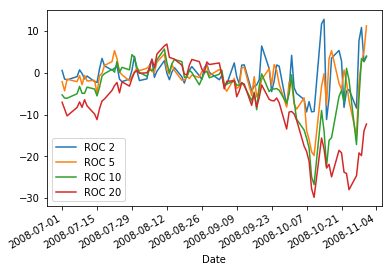

In [9]:
data['2008-07': '2008-10'][['ROC 2', 'ROC 5', 'ROC 10', 'ROC 20']].plot()

# Deviation from zero-lag exponential MA

In [10]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

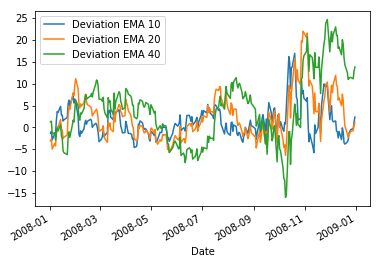

In [11]:
data['2008'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [12]:
for i, j, k in [(12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
    data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
    data[f'MACD hist ({i}, {j}, {k})'] = macdhist

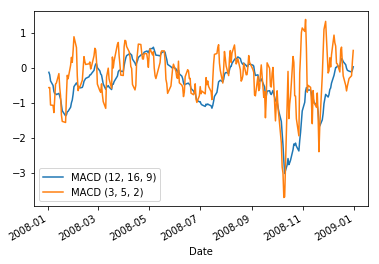

In [13]:
data['2008'][['MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

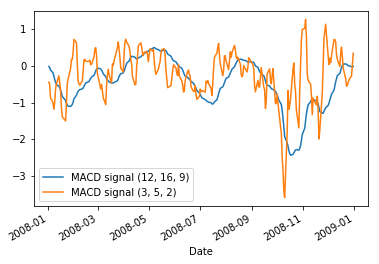

In [14]:
data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

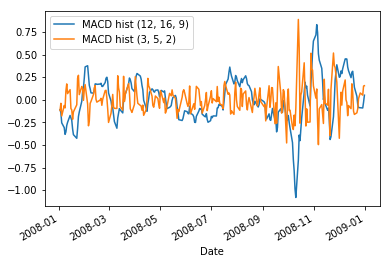

In [15]:
data['2008'][['MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [16]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

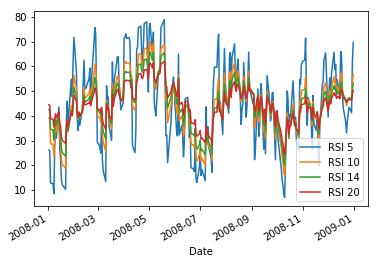

In [17]:
data['2008'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [18]:
for i, j in [(5, 10), (10, 20)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

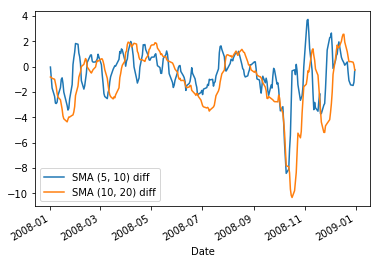

In [19]:
data['2008'][['SMA (5, 10) diff', 'SMA (10, 20) diff']].plot()

# ADX

In [20]:
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)

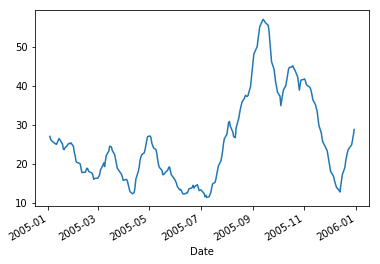

In [21]:
data['2005']['ADX 14'].plot()

# CCI

In [22]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

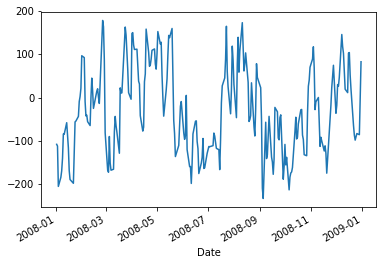

In [23]:
data['2008']['CCI 14'].plot()

# STD deviation 20

In [24]:
data['Std dev 20'] = tl.STDDEV(close, timeperiod=20)

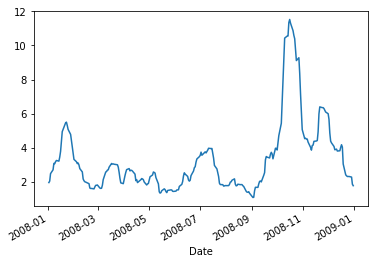

In [25]:
data['2008']['Std dev 20'].plot()

# Y target value

In [26]:
return_day = 5
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Return scaled'] = data['Return'] / (data['Return'].rolling(return_day).std().fillna(1.0))

In [27]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 2,ROC 5,ROC 10,ROC 20,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (12, 16, 9)","MACD signal (12, 16, 9)","MACD hist (12, 16, 9)",...,RSI 10,RSI 14,RSI 20,"SMA (5, 10) diff","SMA (10, 20) diff",ADX 14,CCI 14,Std dev 20,Return,Return scaled
Date,,,,,,,,,,,,,,,,,,,,,
1999-05-05,-0.644864,-0.415512,-0.046339,1.243877,-1.793634,-2.853139,-0.432770,0.239577,0.315609,-0.076032,...,53.024354,53.590987,54.032658,-0.93437,0.93594,20.489020,-11.558144,1.942356,1.437181,1.254787
1999-05-06,0.175178,-0.267523,-1.595153,-0.637330,-1.750246,-3.248888,-1.433450,0.192688,0.291025,-0.098337,...,49.850643,51.333388,52.467542,-0.78906,0.76172,19.845702,-22.992688,1.940844,2.507309,1.941568
1999-05-07,0.139082,1.313321,-0.598251,0.092678,-0.453265,-2.032408,-0.610786,0.190961,0.271012,-0.080052,...,53.632405,53.898380,54.180882,-0.35781,0.67422,19.248335,-3.573762,1.942808,-0.902815,-0.575745
1999-05-10,0.256597,-1.001861,-1.658642,-1.455773,-0.508662,-2.257764,-1.461731,0.161892,0.249188,-0.087296,...,50.815811,51.947877,52.854255,-0.40313,0.54688,18.298311,-26.438913,1.888977,-0.104669,-0.076800
1999-05-11,0.509259,1.448598,-1.138434,0.184587,0.980149,-0.836615,-0.315329,0.186469,0.236644,-0.050176,...,56.009288,55.459840,55.190875,0.14062,0.37813,17.280123,55.896787,1.897725,-1.289728,-0.803775


### Features

In [28]:
feature_names = data.drop(['Return', 'Return scaled'], axis=1).columns

# Train and test Random Forest

In [29]:
def make_X_y(df):
    X = df.drop(['Return', 'Return scaled'], axis=1)
    y = df['Return']
#     y = df['Return scaled']
    ret = df['Return']
    return X, y, ret

In [30]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    ret = ret.iloc[train_size:]
    
    extreme = y_train[-test_size:].std()*std_dev_multiplier
    print(f'Extreme (std dev of y_train): {extreme}')
    
    X_train = pd.concat([X_train, X_train[-50:], X_train[-25:], X_train[-10:], X_train[-5:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-50:], y_train[-25:], y_train[-10:], y_train[-5:]], ignore_index=True)
    return X_train, X_test, y_train, y_test, ret, extreme

In [31]:
def to_class(val, extreme):
    if val < -extreme:
        return 'Neg'
    elif val > extreme:
        return 'Pos'
    else:
        return 'Neutral'

In [32]:
def convert_y_to_labels(y_train, y_test, extreme):
    y_train = y_train.apply(lambda val: to_class(val, extreme))
    y_test = y_test.apply(lambda val: to_class(val, extreme))
    
    def distrib_print(vec):
        print('Distribution:\n' + str(vec.value_counts()) + '\n---')
        
    distrib_print(y_train)
    distrib_print(y_test)
    
    return y_train, y_test

In [33]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred):
    bad = ((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos'))
    bad_sum = -14*np.sum(bad)
    avg = ((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg'))
    avg_sum = -2*np.sum(avg)
    good = ((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg'))
    good_sum = 7*np.sum(good)
    return bad_sum + good_sum
scorer = make_scorer(custom_loss, greater_is_better=True)

In [34]:
def calculate_returns(ret, y_pred):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    return ret_sum

In [35]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [36]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, ret, extreme = split_X_y(X, y, ret)
    y_train, y_test = convert_y_to_labels(y_train, y_test, extreme)
    
    params = {'n_estimators': [20,100],
#               'max_depth': [3,4,None],
              'max_features': [2,3,4],
              'min_samples_split': [2,3,4],
              'min_samples_leaf': [1,2,3]}
    grid = GridSearchCV(estimator=RandomForestClassifier(n_jobs=6, class_weight='balanced_subsample', max_depth=None),
                        param_grid=params, 
                        scoring=scorer)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum = calculate_returns(ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.iloc[0].name,
        'best_params': best_params,
        'features': best_estimator.feature_importances_,
        'ret_sum': ret_sum
    }
    test_params.append(param)

In [37]:
test_params = []

for i in range(1800, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 2006-06-30 00:00:00 to 2007-06-28 00:00:00
Extreme (std dev of y_train): 1.9601922840448345
Distribution:
Neutral    241
Pos         35
Neg         14
Name: Return, dtype: int64
---
Distribution:
Neutral    41
Neg         5
Pos         4
Name: Return, dtype: int64
---


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.82      1.00      0.90        41
        Pos       0.00      0.00      0.00         4

avg / total       0.67      0.82      0.74        50

---
Confusion matrix
 [[ 0  5  0]
 [ 0 41  0]
 [ 0  4  0]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-09-12 00:00:00 to 2007-09-10 00:00:00
Extreme (std dev of y_train): 1.3755834161213107
Distribution:
Neutral    193
Pos         64
Neg         33
Name: Return, dtype: int64
---
Distribution:
Neutral    25
Pos        14
Neg        11
Name: Return, dtype: int64
---


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00        11
    Neutral       0.71      0.60      0.65        25
        Pos       0.41      0.86      0.56        14

avg / total       0.47      0.54      0.48        50

---
Confusion matrix
 [[ 0  4  7]
 [ 0 15 10]
 [ 0  2 12]]
1.5846485054548998 [long] + 0.0 [short] = 1.5846485054548998
From 2006-11-21 00:00:00 to 2007-11-19 00:00:00
Extreme (std dev of y_train): 2.2059580972908623
Distribution:
Neutral    235
Neg         29
Pos         26
Name: Return, dtype: int64
---
Distribution:
Neutral    33
Neg        11
Pos         6
Name: Return, dtype: int64
---


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00        11
    Neutral       0.67      0.94      0.78        33
        Pos       0.25      0.17      0.20         6

avg / total       0.47      0.64      0.54        50

---
Confusion matrix
 [[ 0 10  1]
 [ 0 31  2]
 [ 0  5  1]]
-1.4407600351322603 [long] + 0.0 [short] = -1.4407600351322603
From 2007-02-06 00:00:00 to 2008-02-01 00:00:00
Extreme (std dev of y_train): 2.1336174743495957
Distribution:
Neutral    203
Neg         55
Pos         32
Name: Return, dtype: int64
---
Distribution:
Neutral    22
Neg        17
Pos        11
Name: Return, dtype: int64
---


KeyboardInterrupt: 

### Accuracy

In [ ]:
accuracies = [d['accuracy'] for d in test_params]
np.average(accuracies)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(accuracies)
for a,b in zip(np.arange(len(accuracies)), accuracies): 
    plt.text(a, b, str(b), fontsize=8)

### Random Forest parameters

In [ ]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=[d['date'] for d in test_params])
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = accuracies

In [ ]:
params.sort_values('Accuracy', ascending=False)

In [ ]:
params.describe()

### Feature importances

In [ ]:
features = pd.DataFrame([d['features'] for d in test_params], index=[d['date'] for d in test_params], columns=feature_names)

In [ ]:
features

In [ ]:
features.idxmax(axis=1)

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

In [ ]:
plt.figure(figsize=(15,10))
sns.violinplot(data=features)